<a href="https://colab.research.google.com/github/kaitken17/colab_based_projects/blob/master/rnn_multiclass/mnist_analysis_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 8.0MB/s 


In [ ]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [ ]:
# Skips any tests and just runs function definitions
run_tests = False

# Load In Data

#### PyTorch

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets

train_data = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def convert_serialized_mnist(train_data, test_data, smnist_params, train_params):
  """
  Prunes classes in MNIST and converts into serialized data
  """

  mnist_classes = smnist_params['mnist_classes']
  n_classes = len(mnist_classes)
  n_len = smnist_params['n_len']
  n_inputs = smnist_params['n_inputs']
  time_dim = smnist_params['time_dim']
  trim_zeros = smnist_params['trim_zeros'] if 'trim_zeros' in smnist_params else False # Removes zeros from image
  pull_zeros = smnist_params['pull_zeros'] if 'pull_zeros' in smnist_params else False # Pulls zeros to end
  push_zeros = smnist_params['push_zeros'] if 'push_zeros' in smnist_params else False # Pushes zeros to start
  rand_start = smnist_params['rand_start'] if 'rand_start' in smnist_params else False
  shuffle_sequence = smnist_params['shuffle_sequence'] if 'shuffle_sequence' in smnist_params else False
  batch_size = train_params['batch_size']

  # Prunes classes that are not in 'mnist_classes'
  target_bools = np.zeros((n_classes, len(train_data.targets)))
  for digit_idx in range(len(mnist_classes)):
    target_bools[digit_idx] = train_data.targets==mnist_classes[digit_idx]

  idx = []
  for mnist_idx in range(len(train_data.targets)):
    if target_bools[:, mnist_idx].any(): idx.append(mnist_idx)

  train_data_subset = torch.utils.data.Subset(train_data, idx)
  trainset = torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True)

  test_bools = np.zeros((n_classes, len(test_data.targets)))
  for digit_idx in range(len(mnist_classes)):
    test_bools[digit_idx] = test_data.targets==mnist_classes[digit_idx]

  idx = []
  for mnist_idx in range(len(test_data.targets)):
    if test_bools[:, mnist_idx].any(): idx.append(mnist_idx)

  test_data_subset = torch.utils.data.Subset(test_data, idx)
  testset = torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True)

  def convert_to_jax(dataset):
    """ Converts dataset into JAX """
    images_np = np.zeros((len(dataset)-1, batch_size, n_len, n_inputs)) # batch number x batch_index x n_len x n_inputs
    labels_np = np.zeros((len(dataset)-1, batch_size, n_len, n_classes)) # batch number x batch_index x one-hot-vector
    masks_np = np.zeros((len(dataset)-1, batch_size, 1))
    counter = 0
    for train_vals, idx in zip(dataset, range(len(dataset))):
      images, labels = train_vals[0], train_vals[1]
      squeezed_images = np.squeeze(images.numpy())
      if squeezed_images.shape[0] == batch_size: 
        batch_images_squeezed = np.squeeze(images.numpy())
        if shuffle_sequence:
          if time_dim == 'Rows':
            for batch_idx in range(batch_size):
              temp_image = batch_images_squeezed[batch_idx].reshape(n_len, n_inputs)
              np.random.shuffle(temp_image)
              images_np[idx][batch_idx] = temp_image
          elif time_dim == 'Columns':
            batch_images_columns = np.swapaxes(batch_images_squeezed, 1, 2)
            for batch_idx in range(batch_size):
              temp_image = batch_images_columns[batch_idx].reshape(n_len, n_inputs)
              np.random.shuffle(temp_image)
              images_np[idx][batch_idx] = temp_image
          masks_np[idx, :] = (n_len-1) * np.ones((batch_size, 1))
        elif pull_zeros or push_zeros or rand_start: # All affect starting locations, but still pass entire image
          if time_dim == 'Rows':
            raise NotImplementedError('Havent implemented for rows yet')
            for batch_idx in range(batch_size):
              images_np[idx][batch_idx] = 1
          elif time_dim == 'Columns':
            batch_images_columns = np.swapaxes(batch_images_squeezed, 1, 2)
            for batch_idx in range(batch_size):
              temp_image = batch_images_columns[batch_idx].reshape(n_len, n_inputs)
              if pull_zeros:
                time_idx = 0
                while (temp_image[time_idx] == np.zeros((n_inputs,))).all():
                  time_idx += 1
              elif push_zeros:
                time_idx = n_len - 1
                while (temp_image[time_idx] == np.zeros((n_inputs,))).all():
                  time_idx -= 1
                time_idx += 1 # since end index is inclusive, need to bump this up one
              elif rand_start:
                time_idx = np.random.randint(n_len)
              images_np[idx][batch_idx] = np.concatenate((temp_image[time_idx:], temp_image[:time_idx]))
          masks_np[idx, :] = (n_len-1) * np.ones((batch_size, 1))
        elif trim_zeros:
          if time_dim == 'Rows':
            raise NotImplementedError('Havent implemented for rows yet')
            for batch_idx in range(batch_size):
              images_np[idx][batch_idx] = 1
          elif time_dim == 'Columns':
            batch_images_columns = np.swapaxes(batch_images_squeezed, 1, 2)
            for batch_idx in range(batch_size):
              temp_image = batch_images_columns[batch_idx].reshape(n_len, n_inputs)
              start_idx = 0
              while (temp_image[start_idx] == np.zeros((n_inputs,))).all():
                start_idx += 1
              end_idx = n_len - 1
              while (temp_image[end_idx] == np.zeros((n_inputs,))).all():
                end_idx -= 1
              images_np[idx][batch_idx] = np.concatenate((temp_image[start_idx:], temp_image[:start_idx]))
              masks_np[idx][batch_idx] = end_idx - start_idx
        else:
          if time_dim == 'Rows':
            images_np[idx] = batch_images_squeezed.reshape(batch_size, n_len, n_inputs)
          elif time_dim == 'Columns':
            batch_images_columns = np.swapaxes(batch_images_squeezed, 1, 2)
            images_np[idx] = batch_images_columns.reshape(batch_size, n_len, n_inputs)
          masks_np[idx, :] = (n_len-1) * np.ones((batch_size, 1))
        for label, lbl_idx in zip(labels, range(len(labels))):
          one_hot = np.zeros((n_len, n_classes,))
          one_hot[:, mnist_classes.index(label)] = np.ones((n_len,))
          labels_np[idx, lbl_idx] = one_hot
      else:
        print('Omitting incomplete batch')

    jax_data = {
      'inputs': jnp.asarray(images_np),  # batch number x batch_index x n_len x n_inputs
      'labels': jnp.asarray(labels_np), # batch number x batch_index x n_len x one-hot-vector
      'index': jnp.asarray(masks_np, dtype=jnp.int32), # Target mask: list of integers up to phrase_len
    }
    
    return jax_data

  train_jax = convert_to_jax(trainset)
  test_jax = convert_to_jax(testset)

  return train_jax, test_jax

run_tests = True
if run_tests:
  smnist_params = {
    'mnist_classes': [3, 4, 7],
    'n_len' : 28,
    'time_dim': 'Columns',
    'shuffle_sequence': False,
    'trim_zeros': True,
    'pull_zeros': False,
    'push_zeros': False,
    'rand_start': False,
  }
  smnist_params['n_inputs'] = int(28*28/smnist_params['n_len'])

  train_params = {'batch_size': 128}
    
  train_jax, test_jax = convert_serialized_mnist(train_data, test_data, smnist_params, train_params)




Omitting incomplete batch
Omitting incomplete batch


[0. 1. 0.]
15


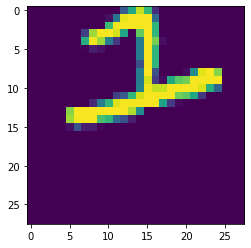

First few inputs


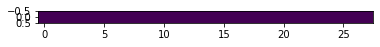

[0. 0. 1.]
11


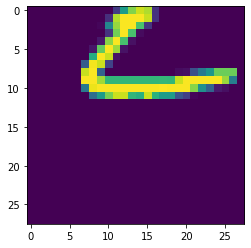

[1. 0. 0.]
13


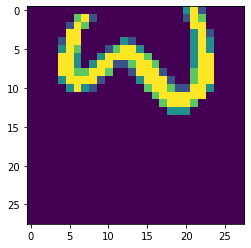

In [ ]:
print(np.asarray(train_jax['labels'][0, 67, np.asarray(train_jax['index'][0, 67, 27])]))
print(np.asarray(train_jax['index'][0, 67, 27]))
plt.imshow(np.asarray(train_jax['inputs'][0, 67]))
plt.show()
print('First few inputs')
plt.imshow(np.asarray(train_jax['inputs'][0, 67, 17:18]))
plt.show()
print(np.asarray(train_jax['labels'][4, 66, 27]))
print(np.asarray(train_jax['index'][4, 66, 27]))
plt.imshow(np.asarray(train_jax['inputs'][4, 66]))
plt.show()
print(np.asarray(train_jax['labels'][82, 13, 27]))
print(np.asarray(train_jax['index'][82, 13, 27]))
plt.imshow(np.asarray(train_jax['inputs'][82, 13]))
plt.show()

# Train and Build Network

#### Training Functions

In [ ]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']
  num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  # Build the RNN cell.
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.rnn.cells.VanillaRNN(num_units)
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.rnn.cells.GRU(num_units)
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.rnn.cells.LSTM(num_units)
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.rnn.cells.UGRNN(num_units)
  if rnn_specs['ro_bias']:
    if rnn_specs['ro_simplex_init']:
      raise NotImplmentedError
    else:
      readout_init, readout_apply = stax.Dense(num_outputs)
  else:
    if rnn_specs['ro_simplex_init']:
      readout_init, readout_apply = Dense_nobias(num_outputs, W_init=simplex_readouts)
    else:
      readout_init, readout_apply = Dense_nobias(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1 = jax.random.split(prng_key, 2)
    output_shape, rnn_params = cell.init(k0, input_shape[1:])
    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)

    return batch_output_shape, (rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, :, jnp.newaxis]
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    xe_loss = -1 * np.mean(logliklihood)

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    
    xe_loss = xe_loss_fn(logits, labels)

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return labels_max == predictions

  return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)
    # Sets readout gradients to zero
    # rnn_grads, ro_grads = gradients
    # ro_grads = optimizers.clip_grads(ro_grads, 0.0)
    # gradients = rnn_grads, ro_grads

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

In [ ]:
def shuffle_data_smnist(train_data):
  """ Shuffles synthetic data for different epochs """
  train_data_input_flat = train_data['inputs'].reshape(train_data['inputs'].shape[0]*train_data['inputs'].shape[1], train_data['inputs'].shape[2], train_data['inputs'].shape[3])
  train_data_label_flat = train_data['labels'].reshape(train_data['labels'].shape[0]*train_data['labels'].shape[1], train_data['labels'].shape[2], train_data['labels'].shape[3])  

  dataset_size = train_data_input_flat.shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  train_data_input_flat= train_data_input_flat[shuf_idxs]
  train_data_label_flat = train_data_label_flat[shuf_idxs]

  train_data_shuf = {
      'inputs': train_data_input_flat.reshape(train_data['inputs'].shape),
      'labels': train_data_label_flat.reshape(train_data['labels'].shape),
      'index': train_data['index'],
  }

  return train_data_shuf

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

def train_on_mnist(train_jax, val_data, opt_state, train_params, smnist_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  for epoch in range(train_params['epochs']):
    # Shuffles training data after first epoch
    if epoch > 0:
      train_jax = shuffle_data_smnist(train_jax)

    # print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
    start_time = time.time()  
    avg_loss = 0 
    for step in range(total_steps, total_steps+num_batchs):
      batch = step - total_steps 
      batch_data = {
        'inputs': train_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
        'labels': train_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
        'index': train_jax['index'][batch], # Target mask: list of integers up to phrase_len
      }

      global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
      train_losses.append(loss)
      avg_loss += loss

      # # Check value of the RO vectors
      # rnn_params, readout_params = get_params(opt_state)
      # wO = readout_params.T
      # print(wO[:2,:2])

      if (global_step+1) % print_every == 0:
        test_acc = test_accuracy(get_params(opt_state), val_data)

        batch_time = time.time() - start_time
        step_size = decay_fun(global_step)
        s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
        print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
        start_time = time.time()
        avg_loss = 0

    train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def full_test_accuracy(test_jax, opt_state, train_params, smnist_params, rnn_specs):
  num_batchs = test_jax['inputs'].shape[0]
  test_acc_batch = np.zeros((num_batchs, ))

  for batch in range(num_batchs):
      batch_data = {
        'inputs': test_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
        'labels': test_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
        'index': test_jax['index'][batch], # Target mask: list of integers up to phrase_len
      }

      test_acc_batch[batch] = test_accuracy(get_params(opt_state), batch_data)

  return np.mean(test_acc_batch)

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""
  if 'variable_length' not in toy_params: toy_params['variable_length'] = False
  if 'min_phrase_len' not in toy_params: toy_params['min_phrase_len'] = 10
  if 'extreme_test' not in toy_params: toy_params['extreme_test'] = False
  if 'base_word_vals' not in toy_params: toy_params['base_word_vals'] = baseWordValues(toy_params)
  if  'corr_val' not in  toy_params: toy_params['corr_val'] = 0.0
  if  'corr_vals' not in  toy_params: toy_params['corr_vals'] = {}

  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'

  return train_params, toy_params, rnn_specs

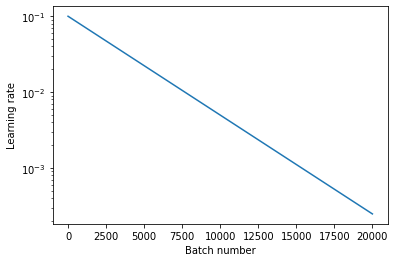

In [ ]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [ ]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## MNIST data parameters ##########
smnist_params = {
  'mnist_classes': [0, 1, 2, 3, 4, 5, 6, 7],
  'n_len' : 28,
  'time_dim': 'Columns',
  'shuffle_sequence': False,
  'trim_zeros': True,
  'pull_zeros': False,
  'push_zeros': False,
  'rand_start': False,
}

smnist_params['n_inputs'] = int(28*28/smnist_params['n_len'])

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                               # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'input_size': smnist_params['n_inputs'],           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(smnist_params['mnist_classes']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 2e-3,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,         # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'epochs': 50,                               # How many times to go through each train set completely
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, decay_rate=train_params['decay_factor'])

# Sets default parameters if they weren't set above
# train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('MNIST Digits:', smnist_params['mnist_classes'])

new_network = True
load_network = False
save_data = True

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/smnist_data/gru_8class01234567_coltimetrimmed_noRO_l2is2e-3.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Arrange MNIST
  train_jax, test_jax = convert_serialized_mnist(train_data, test_data, smnist_params, train_params)
  train_params['num_batchs'] = train_jax['inputs'].shape[0]

  val_data = {
        'inputs': test_jax['inputs'][0], # Phrase tensors: batch x phrase_len x in_dim
        'labels': test_jax['labels'][0], # Sentiment tensors: batch x phrase_len x out_dim
        'index': test_jax['index'][0], # Target mask: list of integers up to phrase_len
      }
  
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], smnist_params['n_len'], smnist_params['n_inputs'])
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  raise NotImplementedError
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:

  raise NotImplementedError

# Generate synthetic data and run training on said data
opt_state, train_params = train_on_mnist(train_jax, val_data, opt_state, train_params, smnist_params, rnn_specs)

test_accuracy_final = full_test_accuracy(test_jax, opt_state, train_params, smnist_params, rnn_specs)
print('Full test accuracy:', test_accuracy_final)

train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), smnist_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

MNIST Digits: [0, 1, 2, 3, 4, 5, 6, 7]
Omitting incomplete batch
Omitting incomplete batch
Step 100 in 5.28 sec, step size: 0.09707, test acc 0.9297, avg training loss 1.3815
Step 200 in 1.64 sec, step size: 0.09420, test acc 0.9688, avg training loss 0.7145
Step 300 in 1.66 sec, step size: 0.09142, test acc 0.9844, avg training loss 0.5229
Step 400 in 0.38 sec, step size: 0.08872, test acc 0.9141, avg training loss 0.1892
Step 500 in 1.64 sec, step size: 0.08610, test acc 0.9609, avg training loss 0.5970
Step 600 in 1.68 sec, step size: 0.08355, test acc 0.9531, avg training loss 0.5228
Step 700 in 1.65 sec, step size: 0.08108, test acc 0.9688, avg training loss 0.5054
Step 800 in 0.77 sec, step size: 0.07868, test acc 0.9609, avg training loss 0.2404
Step 900 in 1.62 sec, step size: 0.07636, test acc 0.9688, avg training loss 0.4739
Step 1000 in 1.61 sec, step size: 0.07410, test acc 0.9688, avg training loss 0.4590
Step 1100 in 1.60 sec, step size: 0.07191, test acc 0.9688, avg trai

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/smnist_data/gru_3class018_noRO_l2is2e-3.pickle'

# train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), smnist_params, rnn_specs, train_params)

Data Saved


In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/smnist_data/gru_8class01234567_coltimetrimmed_noRO_l2is1e-2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    smnist_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
# train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


Text(0, 0.5, 'Train Loss')

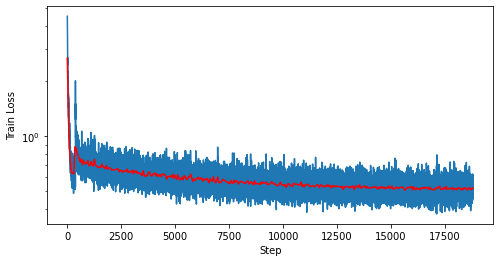

In [ ]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]


plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [ ]:
from scipy.spatial.distance import pdist, squareform

def build_cell(rnn_specs):
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type']  = 'GRU' # Default
  
  print('Using {} cell'.format(rnn_specs['cell_type']))
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.VanillaRNN(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.GRU(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.LSTM(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.UGRNN(rnn_specs['hidden_size'])
  return cell

# Some helper functions to collect RNN hidden states.
@jax.jit
def _get_all_states(inputs, rnn_params):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
  return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, rnn_params, only_final=False):
  """Return (masked) RNN states."""
  states = _get_all_states(batch['inputs'], rnn_params)
  if only_final: # returns only the final hidden state
    return [h[idx[0]] for h, idx in zip(states, batch['index'])]
  else:
    return [h[:idx[0]] for h, idx in zip(states, batch['index'])]

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs

def participation_ratio_vector(C):
  """Computes the participation ratio of a vector of variances."""
  return np.sum(C) ** 2 / np.sum(C*C)

In [ ]:
cell = build_cell(rnn_specs)

n_examples = 500

test_data_input_flat = test_jax['inputs'].reshape(test_jax['inputs'].shape[0]*test_jax['inputs'].shape[1], test_jax['inputs'].shape[2], test_jax['inputs'].shape[3])
test_data_label_flat = test_jax['labels'].reshape(test_jax['labels'].shape[0]*test_jax['labels'].shape[1], test_jax['labels'].shape[2], test_jax['labels'].shape[3])
test_data_index_flat = test_jax['index'].reshape(test_jax['index'].shape[0]*test_jax['index'].shape[1], test_jax['index'].shape[2])   

hs_data = {
    'inputs': test_data_input_flat[:n_examples],
    'labels': test_data_label_flat[:n_examples],
    'index': test_data_index_flat[:n_examples],
}

hs = rnn_states(hs_data, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T
print('Readout shape:', readout.shape)

Using GRU cell
(3671, 128)
Readout shape: (8, 128)


Top 10 components: 0.99215996 ( [0.27394694 0.25774556 0.19833612 0.11415706 0.09608258 0.02812278
 0.01098135 0.00675273 0.00437508 0.00165968] )
Participation Ratio: 4.900373592784561
Copy this: PCA: [0.27394694 0.25774556 0.19833612 0.11415706 0.09608258 0.02812278
 0.01098135 0.00675273 0.00437508 0.00165968] PR: 4.900373592784561
Category 0 states: 58
Category 1 states: 82
Category 2 states: 69
Category 3 states: 57
Category 4 states: 42
Category 5 states: 57
Category 6 states: 58
Category 7 states: 77
Readout vec proj via PCA: [[ 1.3557817   1.3352063   1.220484    0.48353553  1.4720466   0.9309158
   2.122502    0.31711042]
 [-3.3372526  -3.902512   -3.756153   -3.805014   -3.8892133  -3.3744216
  -3.4947245  -4.201223  ]
 [-0.51721334 -0.3918658   0.43431634 -0.31246364 -1.3310544  -1.0573974
  -0.51054746 -0.59274894]
 [-2.1373088  -1.4542371  -1.208787   -1.2085749  -0.77587944 -1.5747786
  -1.3066654  -1.321139  ]
 [-0.5845308  -0.27564332 -0.90247875 -1.6983074  -0.77007085

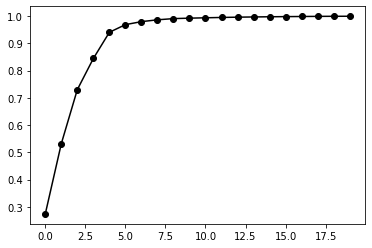

In [ ]:
pc_dims = 10

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(smnist_params['mnist_classes'])):
  states.append([h for h, lbl in zip(hs, hs_data['labels']) if np.argmax(lbl[smnist_params['n_len']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape
print('h0 mag:', np.linalg.norm(h0))

Path label: [0. 0. 0. 0. 0. 0. 0. 1.] Length: 15
Path label: [0. 0. 0. 0. 0. 0. 0. 1.] Length: 13
Path label: [0. 0. 0. 0. 0. 0. 0. 1.] Length: 19


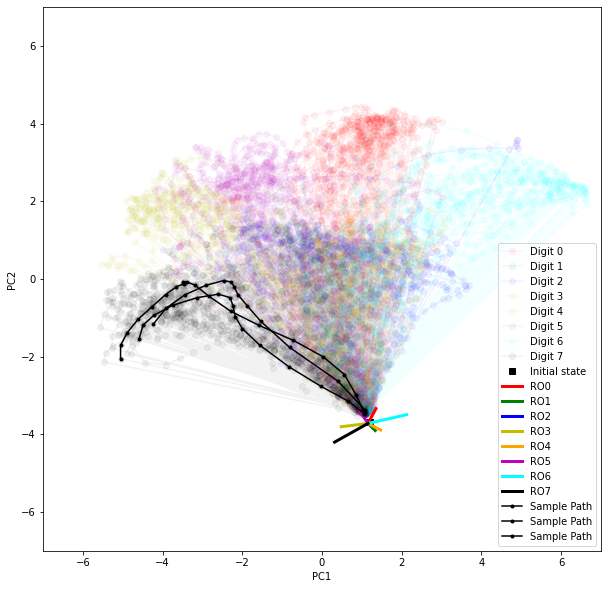

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(10, 10))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['Digit {}'.format(smnist_params['mnist_classes'][i]) for i in range(len(smnist_params['mnist_classes']))]
state_colors = ['r', 'g', 'b', 'y', 'orange', 'm', 'cyan', 'k']
for i in range(len(smnist_params['mnist_classes'])):
  if len(states[i]) > 0:
    pca_states = pca.transform(np.vstack(states[i])).T
    plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.05, label=state_labels[i])

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(smnist_params['mnist_classes'][i]))

path_idxs = [75, 474, 259]
for path_idx in path_idxs:
  path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
  plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(hs_data['labels'][path_idx][smnist_params['n_len']-1])], 
           marker='.', label='Sample Path')
  print('Path label:', hs_data['labels'][path_idx][smnist_params['n_len']-1], 'Length:', len(hs[path_idx]))

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plot_coordinate = 7
plt.xlim(-plot_coordinate, plot_coordinate)
plt.ylim(-plot_coordinate, plot_coordinate)

plt.legend()

#### Readout Vector Analysis

In [ ]:
def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x 1 vector
  Finds the percentage of b's magnitude which lies in the subspace formed by the columns of A (its columnspace)
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T)
  b_proj = np.matmul(proj, b)

  return np.linalg.norm(b_proj)/np.linalg.norm(b)

# Percentage of readout vector mag in PCA dimensions

if rnn_specs['ro_bias']:
  wO, bO = readout_params
  print('Bias:', bO)
else:
  wO = readout_params
readout = wO.T

readout_mags = []
readout_pca_mags = []
pc_dims = 3
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

print('Theoretical angle:', 180/np.pi * np.arccos(-1/(len(smnist_params['mnist_classes'])-1)))

ro_angles = []
for i in range(len(readout)):
  for j in range(i):
    angle = 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j]))
    ro_angles.append(angle)
    print('Angle ({}, {}):'.format(i,j), angle)
print('Average Angle:', np.mean(ro_angles))


for i in range(len(readout)):
  indices = []
  A = []
  for j in range(len(readout)):
    if i != j:
      A.append(readout[j])
      indices.append(j)
  print('Perc of {} in {}:'.format(i, indices), subspace_perc(np.asarray(A).T, readout[i]))

Readout 0 mag: 1.0074732
Readout 0 (perc in first 3 PC dims): 0.42957443
Readout 1 mag: 1.1351836
Readout 1 (perc in first 3 PC dims): 0.25880724
Readout 2 mag: 1.0820279
Readout 2 (perc in first 3 PC dims): 0.89842373
Readout 3 mag: 1.1118966
Readout 3 (perc in first 3 PC dims): 0.64049566
Readout 4 mag: 1.0760286
Readout 4 (perc in first 3 PC dims): 0.8118624
Readout 5 mag: 0.9871764
Readout 5 (perc in first 3 PC dims): 0.6739015
Readout 6 mag: 1.0622841
Readout 6 (perc in first 3 PC dims): 0.93569714
Readout 7 mag: 1.1742504
Readout 7 (perc in first 3 PC dims): 0.82409173
Theoretical angle: 98.21321070173819
Angle (1, 0): 90.16576436544521
Angle (2, 0): 95.61499173811893
Angle (2, 1): 96.6601677754818
Angle (3, 0): 118.96879503879404
Angle (3, 1): 111.43731619575023
Angle (3, 2): 84.16324385867627
Angle (4, 0): 114.3921789741028
Angle (4, 1): 89.8710553631375
Angle (4, 2): 122.75866210355902
Angle (4, 3): 108.56128746079794
Angle (5, 0): 82.3087313858019
Angle (5, 1): 138.4011750011

In [ ]:
for i in range(2, 11):
  print('Angle for {} simplex:'.format(i-1), 180/np.pi * np.arccos(-1/(i-1)))

Angle for 1 simplex: 180.0
Angle for 2 simplex: 120.00000000000001
Angle for 3 simplex: 109.47122063449069
Angle for 4 simplex: 104.47751218592994
Angle for 5 simplex: 101.53695903281549
Angle for 6 simplex: 99.59406822686046
Angle for 7 simplex: 98.21321070173819
Angle for 8 simplex: 97.18075578145829
Angle for 9 simplex: 96.37937020844281


In [ ]:
# Exact symplex numbers

simplex = []
simplex.append(np.asarray([1,0,0]))
simplex.append(np.asarray([-1/3, np.sqrt(8)/3, 0]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, np.sqrt(2/3)]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, -np.sqrt(2/3)]))

read_out_mags = []
for i in range(len(simplex)):
  read_out_mags.append(np.linalg.norm(simplex[i]))

print(read_out_mags)

for i in range(len(simplex)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(simplex[i], simplex[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([simplex[0], simplex[1]]).T
A02 = np.array([simplex[0], simplex[2]]).T
A12 = np.array([simplex[1], simplex[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, simplex[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, simplex[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, simplex[0]))

[1.0, 1.0, 1.0, 1.0]
Angle (1, 0): 109.47122063449069
Angle (2, 0): 109.47122063449069
Angle (2, 1): 109.47122063449069
Angle (3, 0): 109.47122063449069
Angle (3, 1): 109.47122063449069
Angle (3, 2): 109.47122063449069
Perc of 2 in (0,1): 0.5773502691896258
Perc of 1 in (0,2): 0.5773502691896258
Perc of 0 in (1,2): 0.5773502691896257


### Find Fixed Points

Category 0 states: 862
Category 1 states: 986
Category 2 states: 968


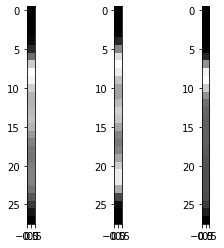

In [ ]:
# dataset = train_jax
dataset = test_jax

phrase_means = np.zeros((dataset['inputs'].shape[0], dataset['inputs'].shape[1], smnist_params['n_inputs']))
labels_no_time = dataset['labels'][:,:, smnist_params['n_len']-1, :]

for batch in range(dataset['inputs'].shape[0]):
  batch_data = {'inputs': test_jax['inputs'][batch]} # Phrase tensors: batch x phrase_len x in_dim
  for batch_idx in range(batch_data['inputs'].shape[0]):
    max_idx = dataset['index'][batch, batch_idx][0]
    phrase_means[batch, batch_idx] = np.mean(batch_data['inputs'][batch_idx][:max_idx+1], axis=0) # Averages over phrase (up to index)

phrase_means = phrase_means.reshape((dataset['inputs'].shape[0]*dataset['inputs'].shape[1], smnist_params['n_inputs']))
phrase_labels = labels_no_time.reshape((dataset['inputs'].shape[0]*dataset['inputs'].shape[1], len(smnist_params['mnist_classes'])))

state_means = []
states = []
for i in range(len(smnist_params['mnist_classes'])):
  states.append([mean for mean, lbl in zip(phrase_means, phrase_labels) if np.argmax(lbl) == i])
  print('Category {} states:'.format(i), len(states[i]))
  state_means.append(np.mean(states[i], axis=0))

mean_input = np.mean(phrase_means, axis=0) # Batches and batch index

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(141)
ax1.imshow(mean_input[:,np.newaxis], cmap='gray')
ax2 = fig.add_subplot(142)
ax2.imshow(state_means[0][:,np.newaxis], cmap='gray')
ax3 = fig.add_subplot(143)
ax3.imshow(state_means[1][:,np.newaxis], cmap='gray')
# ax4 = fig.add_subplot(144)
# ax4.imshow(state_means[2][:,np.newaxis], cmap='gray')

In [ ]:
word_tensor = mean_input
# word_tesnor = state_means[2]

# xstar = jnp.zeros((pts.shape[0], rnn_specs['input_size']))
pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2, num_steps=10000)
print('Done')

  0%|          | 1/10000 [00:00<2:12:10,  1.26it/s]


Done


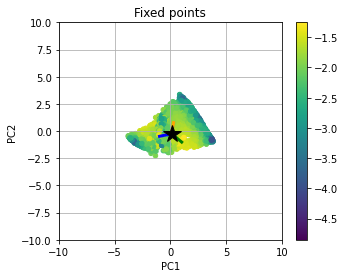

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['g', 'b', 'orange', 'm', 'r']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plot_coordinate = 10
if plot_coordinate != None:
  plt.xlim(-plot_coordinate, plot_coordinate)
  plt.ylim(-plot_coordinate, plot_coordinate)

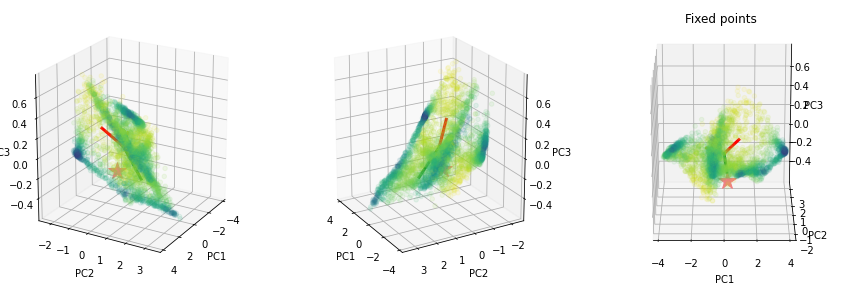

In [ ]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d');
ax2 = fig.add_subplot(132, projection='3d');
ax3 = fig.add_subplot(133, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses), alpha=0.1)
ax2.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses), alpha=0.1)
ax3.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses), alpha=0.1)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
ax2.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
ax3.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  z_ro = [0, ro_dir[pc3]]
  ax.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)
  ax2.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)
  ax3.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))
ax2.set_xlabel('PC'+str(pc1+1))
ax2.set_ylabel('PC'+str(pc2+1))
ax2.set_zlabel('PC'+str(pc3+1))
ax3.set_xlabel('PC'+str(pc1+1))
ax3.set_ylabel('PC'+str(pc2+1))
ax3.set_zlabel('PC'+str(pc3+1))


# for path_idx in path_idxs:
#   path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
#   ax.plot(path_pca[pc1], path_pca[pc2], path_pca[pc3], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.',)
#   ax2.plot(path_pca[pc1], path_pca[pc2], path_pca[pc3], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.',)
#   ax3.plot(path_pca[pc1], path_pca[pc2], path_pca[pc3], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.',)

# Azimuthal angle and rotation
more_rot = 30
ax.view_init(20, 0 + more_rot)
ax2.view_init(20, 120 + more_rot)
ax3.view_init(20, 240 + more_rot)

#### Fixed Point Grid Search


Mean distance: 0.6397235813228117
Treshold conversion: 1.6369850420019363


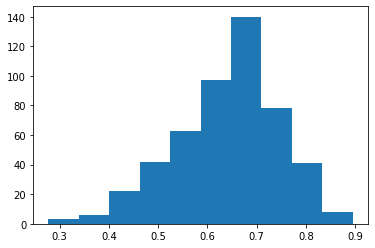

In [ ]:
# Average distance traveled
avg_step_sizes = np.zeros((len(hs),))
for hs_idx in range(len(hs)):
  hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
  total_dist = 0
  for time_idx in range(hs_h0.shape[0] - 1):
    total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
  avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

print('Mean distance:', np.mean(avg_step_sizes))
print('Treshold conversion:', (2*np.mean(avg_step_sizes))**2)

# Histogram of mean distance
plt.hist(avg_step_sizes, bins=10)
plt.show()

In [ ]:
pca_full = PCA(n_components=rnn_specs['hidden_size'])
pts_pca = pca_full.fit_transform(pts)
pr_hs = participation_ratio_vector(pca_full.explained_variance_)
print('Participation Ratio of Hidden States:', pr_hs)

grid_dims = np.int(np.ceil(pr_hs))
print("Grid over first {} PC dimensions".format(grid_dims))

range_extend_ratio = 1 # Amount to extend total range
max_points = 100 # Maximum points along biggest dimension
grid_coords = []
spacing = 0

for dim_idx in range(grid_dims):
  max_co = np.max(pts_pca[:,dim_idx])
  min_co = np.min(pts_pca[:,dim_idx])
  range_co = np.copy(max_co - min_co)

  max_co += range_extend_ratio/2 * range_co # Extend range
  min_co -= range_extend_ratio/2 * range_co

  if dim_idx == 0:
    spacing = (max_co - min_co)/max_points                                    

  grid_coords.append(np.linspace(min_co, max_co, num=np.int(np.ceil((max_co - min_co)/spacing))))
  print('In PC{} dim, using {} points'.format(dim_idx, np.int(np.ceil((max_co - min_co)/spacing))))

# Creates grid and turns them into PCA points
grid_vals = np.asarray(np.meshgrid(*grid_coords))
grid_vals_flat = grid_vals.reshape(grid_vals.shape[0], np.prod(grid_vals.shape[1:]))
print('Total hidden states:',  np.prod(grid_vals.shape[1:]))
pca_points = np.zeros((grid_vals_flat.shape[1], rnn_specs['hidden_size']))
pca_points[:, :grid_dims] = grid_vals_flat.T

# Transform back into hidden state space
hs_grid_points =  jnp.asarray(pca_full.inverse_transform(pca_points))
print('Hs grid points shape', hs_grid_points.shape)

# Fixed point state search
word_tensor = mean_input

hs_ones = jnp.ones((hs_grid_points.shape[0],))
xstar = jnp.outer(hs_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fp_losses = fp_loss_fun(hs_grid_points, xstar)

Participation Ratio of Hidden States: 2.1852888668026083
Grid over first 3 PC dimensions
In PC0 dim, using 100 points
In PC1 dim, using 67 points
In PC2 dim, using 32 points
Total hidden states: 214400
Hs grid points shape (214400, 128)


In [ ]:
thresh = 0.16
hs_grid_thresh = hs_grid_points[fp_losses < thresh]
fp_losses_thresh = fp_losses[fp_losses < thresh]
print('Number of points', hs_grid_thresh.shape[0])

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(hs_grid_thresh)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

Number of points 19961
Top 5 components: 1.0 ( [6.4253998e-01 3.1910944e-01 3.8350593e-02 1.5978672e-13 3.2512013e-15] )
Participation Ratio: 1.9373868490701


Number of points 115966
Number of points 95428
Number of points 76919
Number of points 61535
Number of points 49063
Number of points 39114
Number of points 31195
Number of points 24849
Number of points 19762
Number of points 15662
Number of points 12396
Number of points 9671
Number of points 7474
Number of points 5634
Number of points 4126
Number of points 2795
Number of points 1681
Number of points 838
Number of points 358
Number of points 130


Text(0, 0.5, 'Participation Threshold')

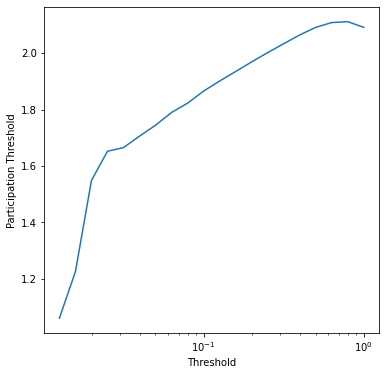

In [ ]:
num_pts = 20
thresh_vals = np.logspace(0, -1.9, num_pts)
pr_vals = np.zeros((num_pts,))
for thresh_idx in range(len(thresh_vals)):
  hs_grid_thresh = hs_grid_points[fp_losses < thresh_vals[thresh_idx]]
  print('Number of points', hs_grid_thresh.shape[0])
  pca_fps = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_fps.fit_transform(hs_grid_thresh)
  pr_vals[thresh_idx] = participation_ratio_vector(pca_fps.explained_variance_)

plt.figure(figsize=(6, 6))
plt.semilogx(thresh_vals, pr_vals)
plt.xlabel('Threshold')
plt.ylabel('Participation Threshold')

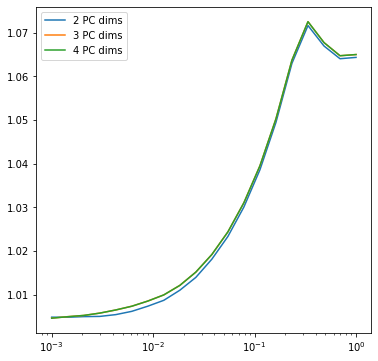

In [ ]:
plt.figure(figsize=(6, 6))
plt.semilogx(thresh_vals, pr_vals2, label = '2 PC dims')
plt.semilogx(thresh_vals, pr_vals3, label = '3 PC dims')
plt.semilogx(thresh_vals, pr_vals4, label = '4 PC dims')
plt.legend()

ValueError: ignored

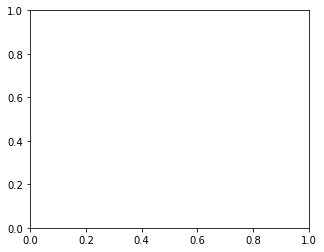

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_hs_grid = pca.transform(np.vstack(hs_grid_thresh)).T
plt.scatter(pca_hs_grid[pc1], pca_hs_grid[pc2], s=20, c=np.log10(fp_losses_thresh), cmap='Greys')
plt.grid()

plt.colorbar()

# Plots readout direction
ro_colors = ['g', 'b', 'orange', 'm', 'r']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plot_coordinate = 8
if plot_coordinate != None:
  plt.xlim(-plot_coordinate, plot_coordinate)
  plt.ylim(-plot_coordinate, plot_coordinate)

#### Single Fixed Point Analysis

In [ ]:
np.argmin(fp_losses)

927

Text(0, 0.5, 'PC2')

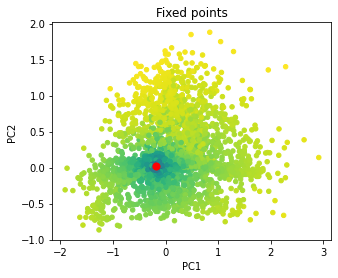

In [ ]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 927
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2],  s=20, c=np.log10(fp_losses))
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, mean_input, fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

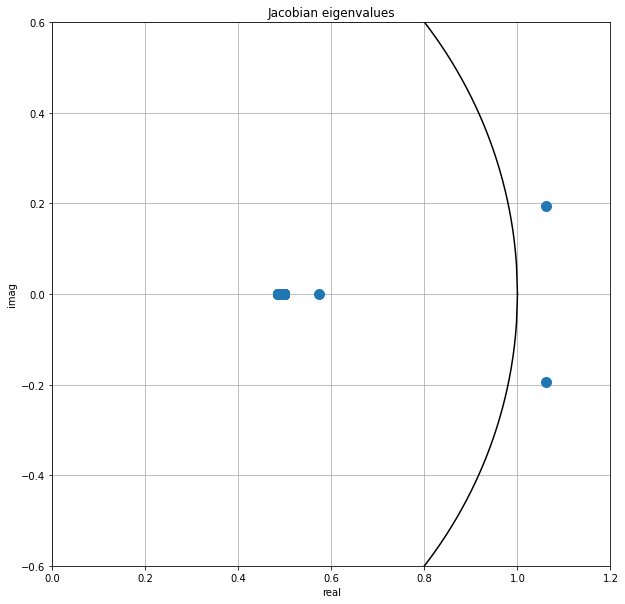

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Many Fixed Point Analysis

In [ ]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [ ]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

Evaluating 10000 fixed points.


Text(0, 0.5, 'Top Im(Eigenvalues)')

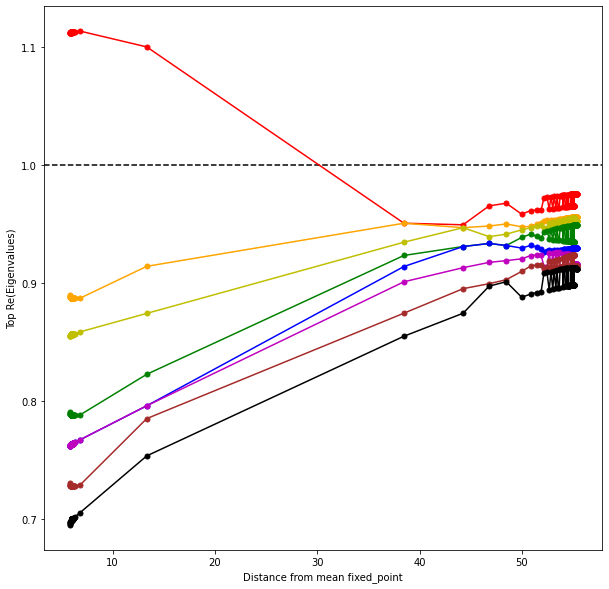

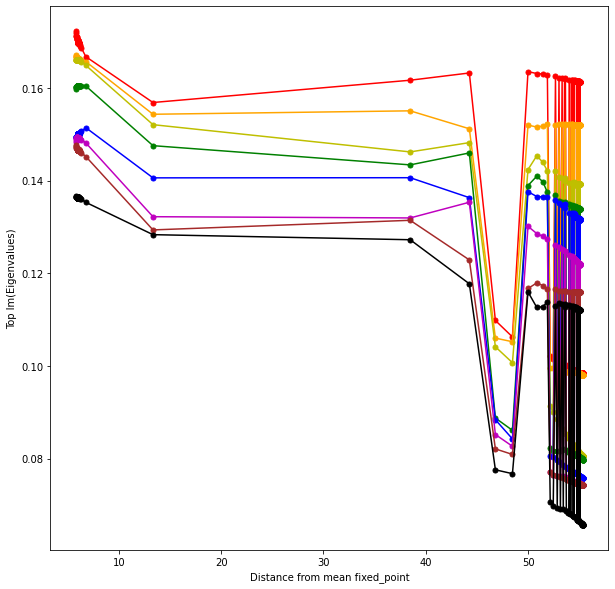

In [ ]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

Number of fixed points: 25000


HS top eigenvalues: [0.8956536+0.j 0.8526117+0.j 0.8031965+0.j]
HS top eigenvalues: [0.89565367+0.j 0.8526116 +0.j 0.8031965 +0.j]
HS top eigenvalues: [1.1041673 +0.j 0.86134094+0.j 0.8294861 +0.j]
HS top eigenvalues: [1.1124028 +0.j 0.8614164 +0.j 0.81864643+0.j]
HS top eigenvalues: [1.0988455 +0.j 0.85771126+0.j 0.8039921 +0.j]


Text(0, 0.5, 'PC2')

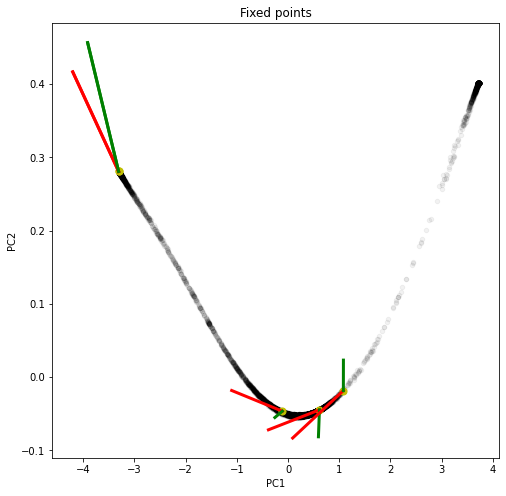

In [ ]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


Text(0, 0.5, 'Perc diff from mean')

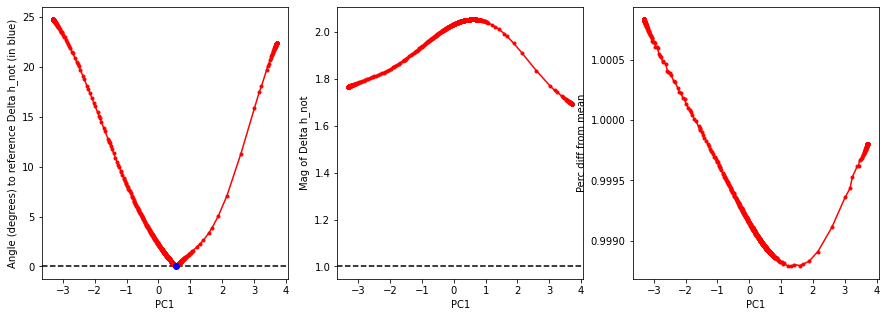

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

Text(0, 0.5, 'PC2')

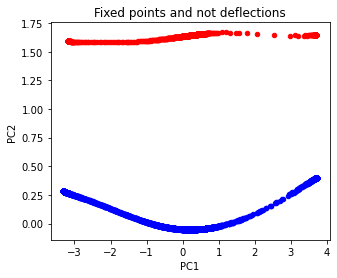

In [ ]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(rnn_specs['output_size'])]
state_colors = ['r', 'b', 'g', 'b', 'm']
for i in range(rnn_specs['output_size']):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.05, label=state_labels[i])

ro_colors = ['r', 'b', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], 
           linewidth = 3, label='RO for '+str(smnist_params['mnist_classes'][i]))

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')
plt.legend()

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

x 1.0
y 1.0
x.y 5.9604645e-08


ValueError: ignored

<Figure size 432x432 with 0 Axes>

x 1.0
y 1.0
x.y 5.9604645e-08


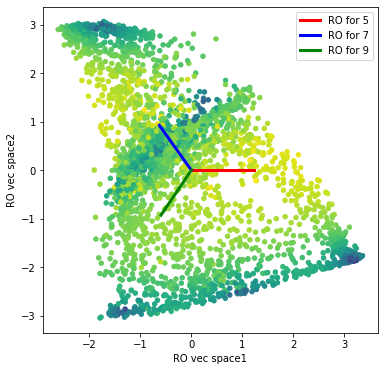

In [ ]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'b', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3, 
           label='RO for '+str(smnist_params['mnist_classes'][i]))

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')
plt.legend()

### FP Manifold Dimension


In [ ]:
unique_tol = 0.025
do_print = True
fps_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)
# fps_reduced = fixed_points
n_fp = fps_reduced.shape[0]

time1 = time.time()
distances = pdist(fps_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 
print('Scipy Eucl Dist Time: {:0.2f} sec.'.format(time.time() - time1))
distances.sort()
print('Min dist:', distances[0])
print('Max dist:', distances[-1])

    Kept 2299/10000 unique fixed points with uniqueness tolerance 0.025000.
Scipy Eucl Dist Time: 0.26 sec.
Min dist: 0.02500274664486267
Max dist: 11.167172991811269


In [ ]:
def find_m_k(k, dist_sq):
  """
  Calculates m_k from Levina, Bickel (Eq. (9))
  
  k: Number of nearest neighbors
  dist_sq: n x n matrix of Euclidean distances between points
  """

  n = dist_sq.shape[0]
  
  m_ks = np.zeros((n,))
  k_eff = k + 1 # Self-distance included, so bump k up by one

  for idx in range(n): # Calculate m_k(x) for all x
    idx_dists = dist_sq[idx, :]
    kidxs = np.argpartition(idx_dists, k_eff)
    max_kdist = np.max(idx_dists[kidxs[:k_eff]])
    sum_of_logs = 0
    for i in range(k_eff):
      if idx_dists[kidxs[i]] > 0: # Ignores self distance
        sum_of_logs += np.log(max_kdist / idx_dists[kidxs[i]])
    m_ks[idx] = 1 / (1/(k - 1) * sum_of_logs)

  return np.mean(m_ks)


# k_vals = np.asarray([int(k_val) for k_val in range(50,80)])
# m_k_means = []
# for k_val in k_vals:
#   m_ks = np.zeros((n_fp,))
#   for i in range(n_fp):
#     m_ks[i] = find_m_k(i, k_val, dist_sq)
#   m_k_means.append(np.mean(m_ks))

k_val = 200
m_k_val = find_m_k(k_val, dist_sq)
print('m_k average:', m_k_val)

m_k average: 1.3098089897964853


k_avged Estimate: 2.033284748961476


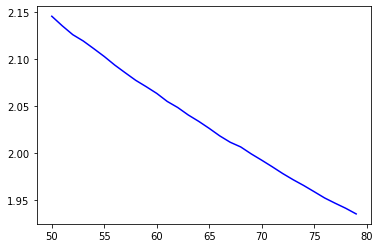

In [ ]:
print('k_avged Estimate:', 1/(np.max(k_vals)-np.min(k_vals)+1)*np.sum(m_k_means))

plt.figure()
plt.plot(k_vals, m_k_means, 'b')

Slope: 1.1424838189591549


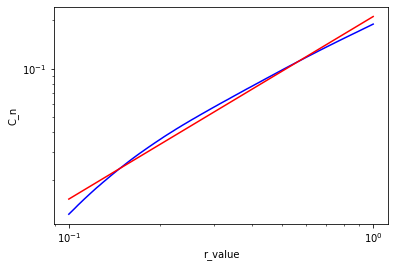

In [ ]:
import scipy
from scipy.spatial.distance import squareform

def find_correlation_dimension(r_val_range, dist_sq, num_pts=100, show_plot=False):
  """ 
  Calculates the linear regression fit of correlation dimension(r). The slope of said result is the estimated dimension

  r_val_range: log10(Range) of r values, specifically np.logspace(r[0], r[1]), 100)
  dist_sq: n x n matrix of Euclidean distances between points
  num_pts: number of points to fit

  Output: slope, intercept, r_value, p_value, std_err of linear regression fit
  """
  n = dist_sq.shape[0]
  distances = squareform(dist_sq)  # Changes to n * (n-1) / 2 vector
  r_values = np.logspace(r_val_range[0], r_val_range[1], num_pts)

  thresh_count = np.asarray([np.count_nonzero(distances < r_val) for r_val in r_values])
  c_n = 2/(n*(n - 1)) * thresh_count

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(r_values), np.log10(c_n))

  if show_plot: # Shows plot of fit
    plt.figure()
    plt.loglog(r_values, c_n, 'b')

    y_fit_values = np.asarray([10**intercept * r_val**slope for r_val in r_values])
    plt.loglog(r_values, y_fit_values, 'r')

    plt.xlabel('r_value')
    plt.ylabel('C_n')

  return slope, intercept, r_value, p_value, std_err

# r_range = (np.log10(1.1*distances[0]),np.log10(distances[-1])z)
r_range = (-1, 0)
slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=True)
print('Slope:', slope)

### Training Paths

#### Rotation/Reflection

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 400

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

pca_full = PCA(n_components=rnn_specs['hidden_size']).fit(pts)
comp = pca_full.components_ # pc_dims x n_hidden

pc_dims = 2

syn_data_path = generate_data(1, toy_params, rnn_specs['output_size'])
hs_path = rnn_states(syn_data_path, rnn_params)[0]
pca_path = np.matmul(hs_path, comp.T) # length x pc_dims

print(syn_data_path['inputs'][0][:5])
print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:5])
path_label = np.argmax(syn_data_path['labels'][0, toy_params['phrase_length']-1])

# # Finds percent of hidden states magnitude explained in first few PCA dimensions
# pca_dims = 3
# perc_mag_hs = np.zeros((hs_path.shape[0],))
# for i in range(hs_path.shape[0]):
#   perc_mag_hs[i] = np.linalg.norm(pca_path[i,:pca_dims])/np.linalg.norm(hs_path[i])

# plt.figure(figsize=(6, 6))
# plt.plot(perc_mag_hs)

rot_label = (path_label + 1) % len(toy_params['sentiments'])
print('Path label: {}, Rotating To: {}'.format(path_label, rot_label))

angle = np.arccos(np.dot(readout[path_label], readout[rot_label])/(np.linalg.norm(readout[path_label])*np.linalg.norm(readout[rot_label])))
rot_matrix = np.identity(hs_path.shape[-1])
rot_matrix[0,0] = np.cos(angle)
rot_matrix[0,1] = np.sin(angle)
rot_matrix[1,0] = -1 * np.sin(angle)
rot_matrix[1,1] = np.cos(angle)
rot_pca_path = np.matmul(pca_path, rot_matrix.T)

comp_inv = np.linalg.inv(comp)
rot_path = np.matmul(rot_pca_path, comp_inv.T)

Using GRU cell
Sythentic data generated in: 0.17 sec.
Sythentic data generated in: 0.00 sec.
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
['kinda2', 'very1', 'the', 'very2', 'the']
Path label: 2, Rotating To: 0


In [ ]:
def pathToPhrase(path_of_hs):
  hs_path_winit = np.concatenate((h0[np.newaxis, :], path_of_hs), axis=0)
  words = []

  for time_idx in range(path_of_hs.shape[0]):
    path_diff = hs_path_winit[time_idx+1] - hs_path_winit[time_idx]
    n_words = len(toy_params['words'])
    word_defs = np.zeros((n_words, hs_path_winit.shape[-1]))
    word_diffs = np.zeros((n_words,))
    input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs_path_winit[time_idx])
    
    for i in range(n_words): # Iterates over all words
      word_tensor = wordToTensor(toy_params['words'][i], toy_params['words'])
      word_defs[i] = np.matmul(input_jac, word_tensor[0])
      word_diffs[i] = np.linalg.norm(word_defs[i] - path_diff)
    words.append(toy_params['words'][np.argmin(word_diffs)])

  return words

rot_phrase_words = pathToPhrase(rot_path)

print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:20])
print(rot_phrase_words[:20])

['kinda2', 'very1', 'the', 'very2', 'the', 'kinda2', 'kinda0', 'kinda2', 'the', 'very2', 'kinda0', 'kinda1', 'very2', 'kinda1', 'very2', 'very2', 'the', 'very1', 'very1', 'very0']
['kinda0', 'very2', 'the', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda2', 'kinda0', 'kinda2', 'kinda0', 'kinda0', 'the', 'very2', 'kinda2', 'kinda0']


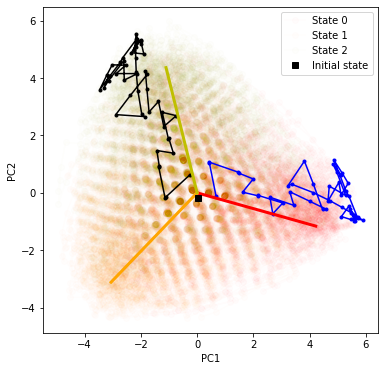

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca_full.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

plt.plot(pca_path[:,pc1], pca_path[:,pc2], c='k', marker='.')
plt.plot(rot_pca_path[:,pc1], rot_pca_path[:,pc2], c='b', marker='.')

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Network Flow

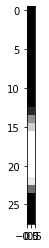

Path label: 0


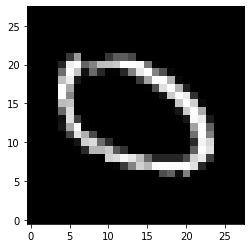

Path label: 0


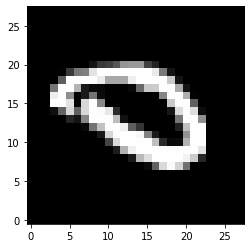

Path label: 1


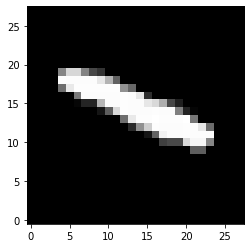

In [ ]:
plt.imshow(test_data_input_flat[252, 12:13].T, origin='upper', cmap='gray' )
plt.show()

path_idxs = [52, 454, 252]
for path_idx in path_idxs:
  print('Path label:', smnist_params['mnist_classes'][np.argmax(hs_data['labels'][path_idx][27])])
  plt.imshow(np.asarray(test_data_input_flat[path_idx]), origin='lower', cmap='gray' )
  plt.show()

In [ ]:
# Shows flow of network at various locations in hidden-state space
pc_dims = 5

flow_points_raw = fixed_points
# flow_points_raw = pts

# Filters out non-unique points
unique_tol = 0.25
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(flow_points_raw, unique_tol, do_print)

points_reduced = points_unique #[::18]

    Kept 242/3914 unique fixed points with uniqueness tolerance 0.250000.


(242, 128)
(242, 128)
(242, 5)
(242, 5)


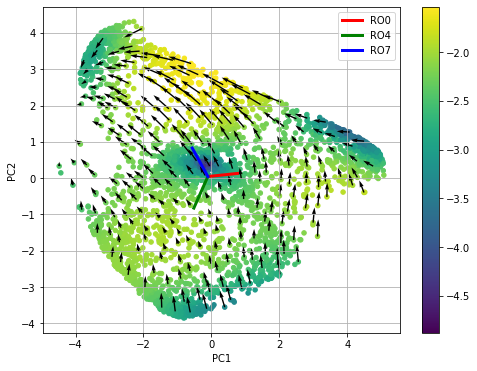

In [ ]:
# Plot the flows
steps = 1

# word_tensor = mean_input
# word_tensor = jnp.zeros(rnn_specs['input_size'])
word_tensor = state_means[2] - mean_input

# word_tensor = test_data_input_flat[52, 11] - mean_input
# word_tensor = test_data_input_flat[454, 10] - mean_input
# word_tensor = test_data_input_flat[252, 12]- mean_input

points_final= np.zeros((len(points_reduced), rnn_specs['hidden_size']))
points_init = np.vstack(points_reduced)
points_final_pca = np.zeros((len(points_reduced), pc_dims))
points_init_pca = pca.transform(np.vstack(points_reduced))
for pt_idx in range(len(points_reduced)):
  ref_point = points_reduced[pt_idx]
  for _ in range(steps):
    ref_point = cell.apply(rnn_params, word_tensor, ref_point)
  points_final[pt_idx] = ref_point
  points_final_pca[pt_idx] = pca.transform(np.atleast_2d(points_final[pt_idx]))[0]

print(points_init.shape)
print(points_final.shape)
print(points_init_pca.shape)
print(points_final_pca.shape)

plt.figure(figsize=(8, 6))

pc1 = 0
pc2 = 1

pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(smnist_params['mnist_classes'][i]))

plt.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], 
           points_final_pca[:,pc1]-points_init_pca[:,pc1], points_final_pca[:,pc2]-points_init_pca[:,pc2])

# pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
# for path_idx in path_idxs:
#   path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
#   plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.', label='Random Path')
#   print('Path label:', hs_data['labels'][path_idx][27])

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plt.legend()

plot_coordinate = None
if plot_coordinate != None:
  plt.xlim(-plot_coordinate, plot_coordinate)
  plt.ylim(-plot_coordinate, plot_coordinate)

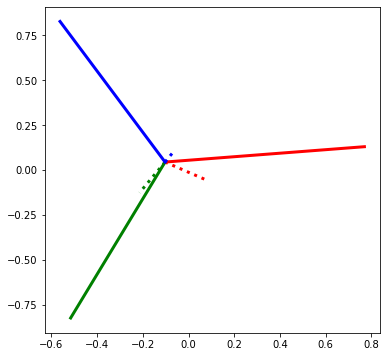

In [ ]:
plt.figure(figsize=(6, 6))

points_final= np.zeros((len(points_reduced), rnn_specs['hidden_size']))
points_init = np.vstack(points_reduced)
points_final_pca = np.zeros((len(points_reduced), pc_dims))
points_init_pca = pca.transform(np.vstack(points_reduced))

mean_def = []
# Calculates the average deflection for each state
for mean_state_input in state_means:
  points_final_pca = np.zeros((len(points_reduced), pc_dims))
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for _ in range(steps):
      ref_point = cell.apply(rnn_params, mean_state_input - mean_input, ref_point)
    points_final[pt_idx] = ref_point
    points_final_pca[pt_idx] = pca.transform(np.atleast_2d(points_final[pt_idx]))[0]

  defs_pca = points_final_pca - points_init_pca
  mean_def.append(np.mean(defs_pca, axis=0))

pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  x_def = [pca_zero[pc1], mean_def[i][pc1]]
  y_def = [pca_zero[pc2], mean_def[i][pc2]]
  plt.plot(x_ro, y_ro, c=state_colors[i], linewidth = 3, label='RO'+str(smnist_params['mnist_classes'][i]))
  plt.plot(x_def, y_def, c=state_colors[i], linestyle='dotted', linewidth = 3)

# Training Analysis

In [ ]:
def pca_analysis(opt_state, toy_params, rnn_specs):
  cell = build_cell(rnn_specs)

  n_trials = 1000 # Number of phrases to gather hidden states from
  rnn_params, readout_params = get_params(opt_state)

  syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

  hs = rnn_states(syn_data_test, rnn_params)
  pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    wO = readout_params
  readout_vecs = wO.T

  # Finds percentage of variance explained by top pc_dims of PCA
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts)
  explained_var = pca_full.explained_variance_ratio_

  return explained_var, readout_vecs

In [ ]:
seed = 342343
print("Seed: %d" % seed)
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : True,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
}

# toy_params['words'] = ['the', 'kinda1100', 'kinda0011', 'kinda1010', 'kinda0101']
toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['words'].remove('very0')
# toy_params['words'].remove('very1')
# toy_params['words'].remove('very2')
# toy_params['words'].remove('very3')
# toy_params['words'].remove('very4')
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
# toy_params['sentiments'] = ['Red', 'Green', 'Blue']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'LSTM',                               # Supports 'GRU' or 'LSTM'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 2e-5,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 100,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 1,                           # Number of new train sets to generate total (this is slow)
  'epochs': 1,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] # Number of examples in train set

Seed: 342343


In [ ]:
num_checkpoints = 100

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2x2class_xe_noRO.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

explained_var = np.zeros((num_checkpoints, rnn_specs['hidden_size']))
if rnn_specs['cell_type'] == 'Vanilla' or rnn_specs['cell_type'] == 'GRU' or rnn_specs['cell_type'] == 'UGRNN' :
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], rnn_specs['hidden_size']))
elif rnn_specs['cell_type'] == 'LSTM':
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], 2*rnn_specs['hidden_size']))
checkpoint_batches = np.zeros((num_checkpoints,))

for cp in range(num_checkpoints):
  # Calculates before train, so checkpoint 0 is initial data
  explained_var[cp], readout_cps[cp] = pca_analysis(opt_state, toy_params, rnn_specs)
  checkpoint_batches[cp] = train_params['global_step']

  # Generate synthetic data and run training on said data
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)

Total words: 9 Words: ['kinda0', 'very0', 'kinda1', 'very1', 'kinda2', 'very2', 'the', 'not', 'extremely']
Total sentiments: 3 Sentiments: ['sent0', 'sent1', 'sent2']
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.43 sec.
Sythentic data generated in: 0.07 sec.
Running batches 0 to 100
Step 100 in 5.93 sec, step size: 0.09707, test acc 0.3600, avg training loss 1.2738
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.48 sec.
Sythentic data generated in: 0.07 sec.
Running batches 100 to 200
Step 200 in 1.95 sec, step size: 0.09420, test acc 0.3400, avg training loss 1.0968
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.35 sec.
Sythentic data generated in: 0.07 sec.
Running batches 200 to 300
Step 300 in 1.96 sec, step size: 0.09142, test acc 0.3650, avg training loss 1.1008
Sythentic data generated in: 0.33 sec.
Sythentic data generated in: 4.38 sec.
Sythentic data generated in: 0.07 sec.
Running batches 300 to 400
Step 40

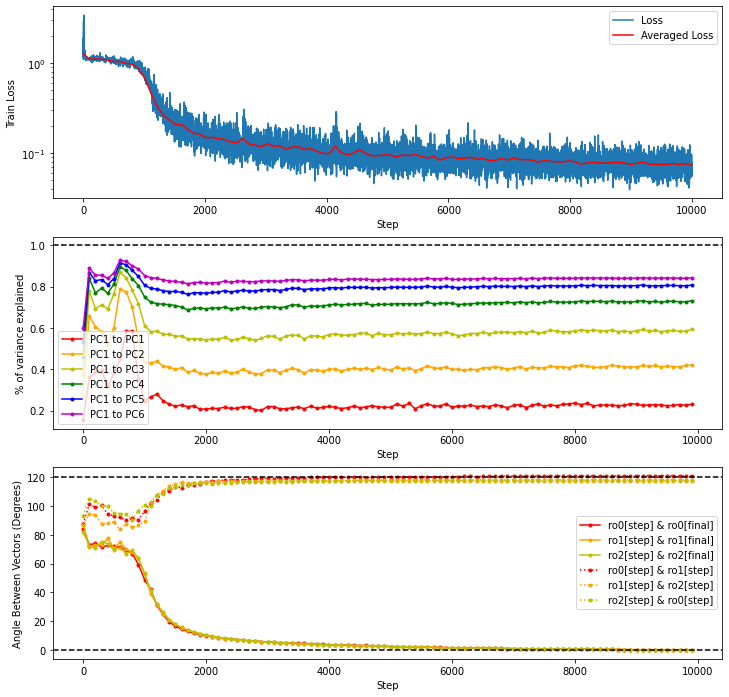

In [ ]:
pc_dims = 5
total_exvar = np.zeros((num_checkpoints, rnn_specs['hidden_size']-1))
ro_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
ro_rel_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
final_ro = readout_cps[num_checkpoints-1] # n_readouts x n_hidden

for cp in range(num_checkpoints):
  # print('Top', pc_dims, 'components:', np.sum(explained_var[cp][:pc_dims]), '(', explained_var[cp][:pc_dims],')')
  for i in range(rnn_specs['hidden_size']-1):
    total_exvar[cp][i] = np.sum(explained_var[cp][:i+1])
  for ro in range(rnn_specs['output_size']):
    dot_val = np.dot(readout_cps[cp][ro], final_ro[ro])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(final_ro[ro]))
    ro_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  for ro in range(rnn_specs['output_size']):
    ro2 = (ro+1) % rnn_specs['output_size']
    dot_val = np.dot(readout_cps[cp][ro],readout_cps[cp][ro2])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(readout_cps[cp][ro2]))
    ro_rel_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  
plt.figure(figsize=(12,12))
# ax1 = plt.subplot('131')
# ax1.plot(total_exvar[0][:20], 'k-', marker='.', label='Initial State')
# ax1.plot(total_exvar[num_checkpoints-1][:20], 'b-', marker='.', label='Final State')
# ax1.set_xlabel('PC Dimension')
# ax1.set_ylabel('% of variance explained')
# ax1.axhline(1.0, c='k', linestyle='--')
# ax1.legend()

ax1 = plt.subplot('311')
train_losses = train_params['train_losses']
n_avg = 100
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]
ax1.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses, label='Loss')
ax1.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r', label='Averaged Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Train Loss')
ax1.legend()

ax2 = plt.subplot('312')
n_pc_dims = 6
plot_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(n_pc_dims):
  ax2.plot(checkpoint_batches, total_exvar[:, i], c = plot_colors[i], marker='.', label='PC1 to PC{}'.format(i+1))
ax2.set_xlabel('Step')
ax2.set_ylabel('% of variance explained')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.legend()

ax3 = plt.subplot('313')
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_angles[:, i], c=plot_colors[i], marker='.', label='ro{}[step] & ro{}[final]'.format(i,i))
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_rel_angles[:, i], c=plot_colors[i], marker='.', linestyle='dotted',
           label='ro{}[step] & ro{}[step]'.format(i,(i+1) % rnn_specs['output_size']))

ax3.set_xlabel('Step')
ax3.set_ylabel('Angle Between Vectors (Degrees)')
ax3.axhline(0.0, c='k', linestyle='--')
ax3.axhline(180/np.pi * np.arccos(-1/(rnn_specs['output_size']-1)), c='k', linestyle='--')
ax3.legend()

### Set Readouts Tests

In [ ]:
def simplex_readouts(rand_seed, dimensions):
  """ Returns readouts which are the vertices of an n-simplex"""
  print('Initializing readouts as simplex dimensions.')
  if len(dimensions) > 2:
    raise NotImplementedError('Only current takes two dimensions, input and output')
  n_readouts = dimensions[1]
  hidden_dim = dimensions[0]
  center = np.zeros((hidden_dim,))
  for i in range(n_readouts):
    center[i] = 1/n_readouts
  readouts = np.zeros((hidden_dim, n_readouts))
  for i in range(n_readouts):
    readouts[i][i] = 1
    readouts[:,i] = center - readouts[:,i]

  return readouts

readouts = simplex_readouts(5, (128, 3)).T
print(readouts.shape)
print(readouts[0][:5])
print(readouts[1][:5])
print(readouts[2][:5])
180/np.pi*np.arccos(np.dot(readouts[0], readouts[1])/(np.linalg.norm(readouts[0]) * np.linalg.norm(readouts[1])))

Initializing readouts as simplex dimensions.
(3, 128)
[-0.66666667  0.33333333  0.33333333  0.          0.        ]
[ 0.33333333 -0.66666667  0.33333333  0.          0.        ]
[ 0.33333333  0.33333333 -0.66666667  0.          0.        ]


120.00000000000001

# Bag of Words Tests

In [ ]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    targets = batch['labels'][:,smnist_params['n_len']-1]
    data_loss = -jnp.mean(jnp.sum(targets * logits, axis=1))
    reg_loss = l2_pen * renn.norm(params)
    return data_loss + reg_loss

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    target_labels = jnp.argmax(batch['labels'][:,smnist_params['n_len']-1], axis=1)
    return jnp.mean(predictions == target_labels)

@jax.jit
def bow_step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params, batch):
    return jnp.array([accuracy(params, batch)])

def full_test_accuracy_bow(test_jax, state):
  num_batchs = test_jax['inputs'].shape[0]
  test_acc_batch = np.zeros((num_batchs, ))

  for batch in range(num_batchs):
      batch_data = {
        'inputs': test_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
        'labels': test_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
        'index': test_jax['index'][batch], # Target mask: list of integers up to phrase_len
      }

      test_acc_batch[batch] = np.mean(test_acc(get_params(state), batch_data))

  return np.mean(test_acc_batch)

In [ ]:
train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.

  'batch_size': 128,         # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'epochs': 50,                               # How many times to go through each train set completely
  'num_batchs': train_jax['inputs'].shape[0]
}

input_shape = (train_params['batch_size'],  smnist_params['n_len'], smnist_params['n_inputs'])
l2_pen = 1e-3

# Linear model
init_fun, apply_fun = stax.serial(
    SequenceSum(),
    stax.Dense(len(smnist_params['mnist_classes'])),
    stax.LogSoftmax,
)

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

f_df = jax.value_and_grad(xent)

# Train
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []
global_step = 0
total_steps = 0
batch_size = train_params['batch_size']
num_batchs = train_params['num_batchs']

val_data = {
      'inputs': test_jax['inputs'][0], # Phrase tensors: batch x phrase_len x in_dim
      'labels': test_jax['labels'][0], # Sentiment tensors: batch x phrase_len x out_dim
      'index': test_jax['index'][0], # Target mask: list of integers up to phrase_len
    }

for epoch in range(train_params['epochs']):
  # Shuffles training data after first epoch
  if epoch > 0:
    train_jax = shuffle_data_smnist(train_jax)

  # print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
  start_time = time.time()  
  avg_loss = 0 
  for step in range(total_steps, total_steps+num_batchs):
    batch = step - total_steps 
    batch_data = {
      'inputs': train_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
      'labels': train_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
      'index': train_jax['index'][batch], # Target mask: list of integers up to phrase_len
    }
    
    state, loss = bow_step(global_step, state, batch_data)
    losses.append(loss)
    avg_loss += loss
    global_step += 1

    if (global_step+1) % train_params['print_every'] == 0:
      acc = np.mean(test_acc(get_params(state), val_data))
      batch_time = time.time() - start_time
      step_size = learning_rate(global_step)
      s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
      print(s.format(global_step+1, batch_time, step_size, acc, avg_loss/train_params['print_every']))
      start_time = time.time()
      avg_loss = 0

full_test_accuracy_bow(test_jax, state)

Step 100 in 1.73 sec, step size: 0.00196, test acc 0.6250, avg training loss 3.2289
Step 200 in 0.37 sec, step size: 0.00191, test acc 0.8984, avg training loss 0.3073
Step 300 in 0.12 sec, step size: 0.00187, test acc 0.9297, avg training loss 0.0489
Step 400 in 0.62 sec, step size: 0.00183, test acc 0.9531, avg training loss 0.2605
Step 500 in 0.48 sec, step size: 0.00179, test acc 0.9609, avg training loss 0.1711
Step 600 in 0.24 sec, step size: 0.00175, test acc 0.9531, avg training loss 0.0775
Step 700 in 0.63 sec, step size: 0.00171, test acc 0.9609, avg training loss 0.1904
Step 800 in 0.62 sec, step size: 0.00167, test acc 0.9609, avg training loss 0.1790
Step 900 in 0.38 sec, step size: 0.00164, test acc 0.9609, avg training loss 0.1020
Step 1000 in 0.12 sec, step size: 0.00160, test acc 0.9688, avg training loss 0.0343
Step 1100 in 0.62 sec, step size: 0.00157, test acc 0.9688, avg training loss 0.1668
Step 1200 in 0.50 sec, step size: 0.00153, test acc 0.9766, avg training l

0.96875

# Many L2 Test

In [ ]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

l2_vals = np.logspace(-3.5, -2.5, 10)

########## MNIST data parameters ##########
smnist_params = {
  'mnist_classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'n_len' : 28,
  'time_dim': 'Columns',
  'shuffle_sequence': False,
  'trim_zeros': True,
  'pull_zeros': False,
  'push_zeros': False,
  'rand_start': False,
}

smnist_params['n_inputs'] = int(28*28/smnist_params['n_len'])

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                               # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'input_size': smnist_params['n_inputs'],           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(smnist_params['mnist_classes']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,         # Total number of batches to train on.
  'print_every': 10000,      # Print training informatino every so often

  'epochs': 30,                               # How many times to go through each train set completely
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, decay_rate=train_params['decay_factor'])

# Sets default parameters if they weren't set above
# train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('MNIST Digits:', smnist_params['mnist_classes'])

# Arrange MNIST
train_jax, test_jax = convert_serialized_mnist(train_data, test_data, smnist_params, train_params)
train_params['num_batchs'] = train_jax['inputs'].shape[0]

val_data = {
  'inputs': test_jax['inputs'][0], # Phrase tensors: batch x phrase_len x in_dim
  'labels': test_jax['labels'][0], # Sentiment tensors: batch x phrase_len x out_dim
  'index': test_jax['index'][0], # Target mask: list of integers up to phrase_len
}

n_examples = 500

test_data_input_flat = test_jax['inputs'].reshape(test_jax['inputs'].shape[0]*test_jax['inputs'].shape[1], test_jax['inputs'].shape[2], test_jax['inputs'].shape[3])
test_data_label_flat = test_jax['labels'].reshape(test_jax['labels'].shape[0]*test_jax['labels'].shape[1], test_jax['labels'].shape[2], test_jax['labels'].shape[3])
test_data_index_flat = test_jax['index'].reshape(test_jax['index'].shape[0]*test_jax['index'].shape[1], test_jax['index'].shape[2])   

hs_data = {
    'inputs': test_data_input_flat[:n_examples],
    'labels': test_data_label_flat[:n_examples],
    'index': test_data_index_flat[:n_examples],
}

test_accs = np.zeros((len(l2_vals),))
var_explained = np.zeros((len(l2_vals), rnn_specs['hidden_size']))
ro_vals = np.zeros((len(l2_vals), len(smnist_params['mnist_classes']), rnn_specs['hidden_size']))

for l2, l2_idx in zip(l2_vals, range(len(l2_vals))):
  print('Testing L2 value:', l2)
  train_params['l2reg'] = l2

  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], smnist_params['n_len'], smnist_params['n_inputs'])
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

  # Generate synthetic data and run training on said data
  opt_state, train_params = train_on_mnist(train_jax, val_data, opt_state, train_params, smnist_params, rnn_specs)

  test_accs[l2_idx] = full_test_accuracy(test_jax, opt_state, train_params, smnist_params, rnn_specs)
  print('Full test accuracy:', test_accs[l2_idx])

  # Destructure the trained parameters of the RNN.
  final_params = get_params(opt_state)
  rnn_params, readout_params = final_params
  
  # Get readouts
  ro_vals[l2_idx] = readout_params.T

  cell = build_cell(rnn_specs)

  hs = rnn_states(hs_data, rnn_params, only_final=False)
  pts = np.vstack(hs)[::2]

  # Finds percentage of variance explained by top pc_dims of PCA
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts)
  var_explained[l2_idx] = pca_full.explained_variance_

MNIST Digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Omitting incomplete batch
Omitting incomplete batch
Testing L2 value: 0.00031622776601683794
Step 10000 in 3.51 sec, step size: 0.00498, test acc 0.9766, avg training loss 0.0029
Full test accuracy: 0.9849759615384616
Using GRU cell
Testing L2 value: 0.00040842386526745213
Step 10000 in 3.36 sec, step size: 0.00498, test acc 0.9609, avg training loss 0.0032
Full test accuracy: 0.9834735576923077
Using GRU cell
Testing L2 value: 0.0005274997063702619
Step 10000 in 3.01 sec, step size: 0.00498, test acc 0.9609, avg training loss 0.0036
Full test accuracy: 0.9820713141025641
Using GRU cell
Testing L2 value: 0.0006812920690579615
Step 10000 in 2.91 sec, step size: 0.00498, test acc 0.9609, avg training loss 0.0040
Full test accuracy: 0.9814703525641025
Using GRU cell
Testing L2 value: 0.0008799225435691075
Step 10000 in 3.05 sec, step size: 0.00498, test acc 0.9375, avg training loss 0.0046
Full test accuracy: 0.9791666666666666
Using GRU cell
T

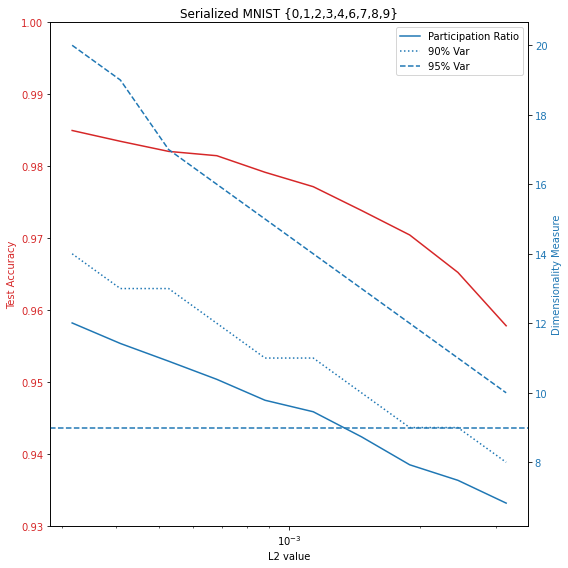

In [ ]:
def participation_ratio_vector(C):
  """Computes the participation ratio of a vector of variances."""
  return np.sum(C) ** 2 / np.sum(C*C)

ve_threshold_90 = np.zeros((len(l2_vals),))
ve_threshold_95 = np.zeros((len(l2_vals),))

for l2_idx in range(len(l2_vals)):
  num_fp_dims = 1
  while np.sum(var_explained[l2_idx][:num_fp_dims]/np.sum(var_explained[l2_idx])) < 0.9:
    num_fp_dims += 1
  ve_threshold_90[l2_idx] = num_fp_dims
  num_fp_dims = 1
  while np.sum(var_explained[l2_idx][:num_fp_dims]/np.sum(var_explained[l2_idx])) < 0.95:
    num_fp_dims += 1
  ve_threshold_95[l2_idx] = num_fp_dims

fig, ax1 = plt.subplots(figsize=(8,8))
ax1.set_title('Serialized MNIST {0,1,2,3,4,6,7,8,9}', fontsize=12)

color = 'tab:red'
ax1.set_xlabel('L2 value')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.semilogx(l2_vals, test_accs, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0.93, 1.0])
# ax1.axhline(0.92, linestyle='dashed', c=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

pr_vals = np.zeros((len(l2_vals),))
for l2_idx in range(len(l2_vals)):
  pr_vals[l2_idx] = participation_ratio_vector(var_explained[l2_idx])

color = 'tab:blue'
ax2.set_ylabel('Dimensionality Measure', color=color)  # we already handled the x-label with ax1
ax2.semilogx(l2_vals, pr_vals, color=color, label='Participation Ratio')
ax2.semilogx(l2_vals, ve_threshold_90, linestyle='dotted', color=color, label='90% Var')
ax2.semilogx(l2_vals, ve_threshold_95, linestyle='dashed', color=color, label='95% Var')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(9, linestyle='dashed', c=color)
ax2.legend()


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

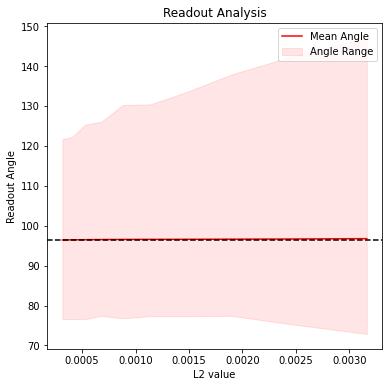

In [ ]:
ro_angles = []
for l2_idx in range(len(l2_vals)):
  ro_angles_l2 = []
  readout = ro_vals[l2_idx]
  for i in range(len(readout)):
    for j in range(i):
      angle = 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(np.linalg.norm(readout[i])*np.linalg.norm(readout[j])))
      ro_angles_l2.append(angle)
  ro_angles.append(ro_angles_l2)

mean_angle = np.zeros((len(l2_vals),))
min_angle = np.zeros((len(l2_vals),))
max_angle = np.zeros((len(l2_vals),))
angle_14 = np.zeros((len(l2_vals),))
angle_34 = np.zeros((len(l2_vals),))

for l2_idx in range(len(l2_vals)):
  mean_angle[l2_idx] = np.mean(ro_angles[l2_idx])
  min_angle[l2_idx] = np.min(ro_angles[l2_idx])
  max_angle[l2_idx] = np.max(ro_angles[l2_idx])
  angle_14[l2_idx] = np.percentile(ro_angles[l2_idx], 25)
  angle_34[l2_idx] = np.percentile(ro_angles[l2_idx], 75)

plt.figure(figsize=(6, 6))
plt.plot(l2_vals, mean_angle, c='r', label='Mean Angle')
# plt.plot(l2_vals, angle_14, c='r', label='1/4 Angle')
# plt.plot(l2_vals, angle_34, c='r', label='3/4 Angle')
plt.fill_between(l2_vals, min_angle, max_angle, color='r', alpha=0.1, label='Angle Range')
# plt.axhline(98.21321070173819, linestyle='dashed', c='k')
# plt.axhline(99.59406822686046, linestyle='dashed', c='b', alpha=0.1)
plt.axhline(96.37937020844281, linestyle='dashed', c='k', alpha=1.0)
plt.title('Readout Analysis')
plt.xlabel('L2 value')
plt.ylabel('Readout Angle')
plt.legend()